In [83]:
import numpy as np

np.random.seed(42)

# Define the ReLU activation function and its derivative
def relu(x):
    return np.maximum(0, x)

def relu_prime(x):
    return (x > 0).astype(float)

# Define the softmax activation function and its derivative
def softmax(x):
    exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))
    return exp_x / np.sum(exp_x, axis=1, keepdims=True)

def softmax_prime(x):
    s = softmax(x)
    return s * (1 - s)

# Define a class for the input layer
class InputLayer:
    def __init__(self, input_size):
        self.input_size = input_size

class HiddenLayer:
    def __init__(self, input_size, hidden_size, activation=relu, activation_prime=relu_prime):
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.activation = activation
        self.activation_prime = activation_prime
        self.W = np.random.randn(input_size, hidden_size) * np.sqrt(2 / input_size)
        self.b = np.random.randn(hidden_size) * 0.01

    def forward(self, X):
        self.Z = X.dot(self.W) + self.b
        self.A = self.activation(self.Z)
        return self.A

    def backward(self, X, dA):
        if self.activation_prime == softmax_prime:  # output layer
            self.dZ = dA
        else:  # hidden layer
            self.dZ = dA * self.activation_prime(self.Z)
        self.dW = X.T.dot(self.dZ) / X.shape[0]
        self.db = np.sum(self.dZ, axis=0) / X.shape[0]
        self.dX = self.dZ.dot(self.W.T)
        return self.dX

    def update(self, learning_rate):
        self.W -= learning_rate * self.dW
        self.b -= learning_rate * self.db


# Define a class for the neural network
class NeuralNetwork:
    def __init__(self, input_size, hidden_size, output_size, learning_rate=0.1):
        self.input_layer = InputLayer(input_size)
        self.hidden_layer = HiddenLayer(input_size, hidden_size)
        self.output_layer = HiddenLayer(hidden_size, output_size, activation=softmax, activation_prime=softmax_prime)
        self.learning_rate = learning_rate
        self.loss = lambda y_true, y_pred: -np.sum(y_true * np.log(y_pred + 1e-9)) / y_true.shape[0]

    def forward(self, X):
        A1 = self.hidden_layer.forward(X)
        A2 = self.output_layer.forward(A1)
        return A2

    def backward(self, X, y):
        dA2 = self.output_layer.A - y
        dA1 = self.output_layer.backward(self.hidden_layer.A, dA2)
        self.hidden_layer.backward(X, dA1)

    def update(self):
        self.hidden_layer.update(self.learning_rate)
        self.output_layer.update(self.learning_rate)

    def train(self, X, y, epochs):
        batch_size = 32
        accuracies = []
        losses = []
        for epoch in range(epochs):
            permutation = np.random.permutation(X.shape[0])
            X = X[permutation]
            y = y[permutation]
            n_batches = X.shape[0] // batch_size
            for i in range(n_batches):
                X_batch = X[i * batch_size : (i + 1) * batch_size]
                y_batch = y[i * batch_size : (i + 1) * batch_size]
                y_pred = self.forward(X_batch)
                self.backward(X_batch, y_batch)
                self.update()
            y_pred = self.forward(X)
            loss = self.loss(y, y_pred)
            accuracy = np.mean(np.argmax(y, axis=1) == np.argmax(y_pred, axis=1))
            accuracies.append(accuracy)
            losses.append(loss)
            print(f"Epoch {epoch+1}, Loss: {loss:.4f}, Accuracy: {accuracy:.4f}")
        return losses, accuracies

In [95]:
def normalize(data):
    # Compute the means and standard deviations of each column using pandas methods
    means = data.mean(axis=0)
    stds = data.std(axis=0)
    # Normalize the data by subtracting the means and dividing by the standard deviations using pandas broadcasting
    data = (data - means) / stds
    # Return the normalized data
    return data

import pandas as pd
import numpy as np
df = pd.read_csv('Acoustic Features.csv')
# drop duplicate
df = df.drop_duplicates(keep='first')
# Split feature and target
X = df.drop(columns=['Class'])
y = df['Class']
X = normalize(X)
y = pd.get_dummies(y, columns = ['Class'])


Epoch 1, Loss: 1.2550, Accuracy: 0.4639
Epoch 2, Loss: 1.0628, Accuracy: 0.5851
Epoch 3, Loss: 0.9240, Accuracy: 0.6495
Epoch 4, Loss: 0.8031, Accuracy: 0.6907
Epoch 5, Loss: 0.6920, Accuracy: 0.7423
Epoch 6, Loss: 0.6010, Accuracy: 0.7758
Epoch 7, Loss: 0.5337, Accuracy: 0.8041
Epoch 8, Loss: 0.4852, Accuracy: 0.8144
Epoch 9, Loss: 0.4448, Accuracy: 0.8325
Epoch 10, Loss: 0.4139, Accuracy: 0.8299
Epoch 11, Loss: 0.3889, Accuracy: 0.8582
Epoch 12, Loss: 0.3663, Accuracy: 0.8763
Epoch 13, Loss: 0.3463, Accuracy: 0.8763
Epoch 14, Loss: 0.3297, Accuracy: 0.8840
Epoch 15, Loss: 0.3153, Accuracy: 0.8892
Epoch 16, Loss: 0.3019, Accuracy: 0.8840
Epoch 17, Loss: 0.2916, Accuracy: 0.8995
Epoch 18, Loss: 0.2813, Accuracy: 0.8943
Epoch 19, Loss: 0.2704, Accuracy: 0.9021
Epoch 20, Loss: 0.2612, Accuracy: 0.9021
Epoch 21, Loss: 0.2530, Accuracy: 0.9072
Epoch 22, Loss: 0.2456, Accuracy: 0.9124
Epoch 23, Loss: 0.2403, Accuracy: 0.9124
Epoch 24, Loss: 0.2324, Accuracy: 0.9253
Epoch 25, Loss: 0.2260, A

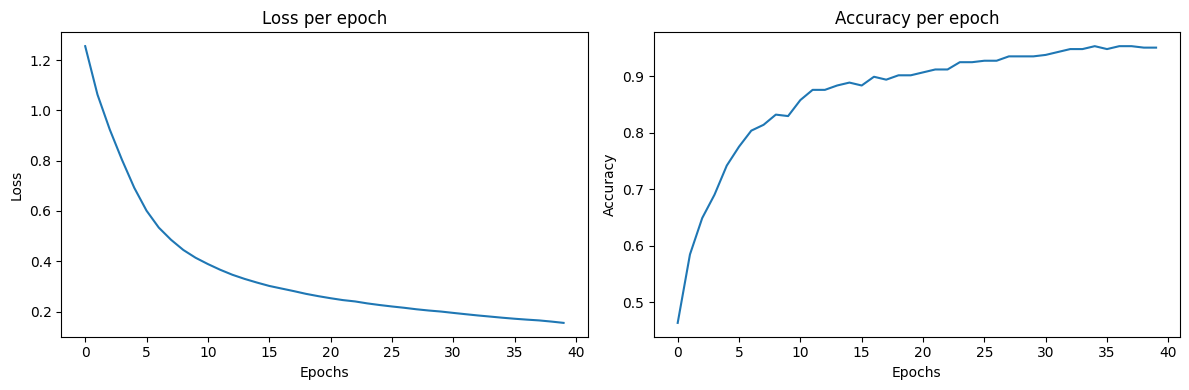

In [96]:

import matplotlib.pyplot as plt
# Create an instance of the neural network with 10 input features, 5 hidden units, and 3 output classes
nn = NeuralNetwork(X.shape[1], 8, y.shape[1], 0.1)

# Train the neural network for 20 epochs
losses , accuracies = nn.train(X.to_numpy(), y.to_numpy(), 40)

# Plotting the loss and accuracy
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(losses)
plt.title('Loss per epoch')
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.subplot(1, 2, 2)
plt.plot(accuracies)
plt.title('Accuracy per epoch')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.tight_layout()
plt.show()